In [2]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [3]:
experiment_name = 'B01'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

In [4]:
ss1,ss3 = [11,21],[13,23]
color,ori = [11,13],[21,23]

In [41]:
time_window = 50
time_step = 25
trial_average = 20
n_splits =10 
group_dict = {0:ss1,1:ss3}

wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)
clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=2)

In [40]:

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    print(np.unique(ydata,return_counts=True))

0
(array([11, 13, 21, 23], dtype=uint8), array([266, 268, 263, 260], dtype=int64))
1
(array([11, 13, 21, 23], dtype=uint8), array([208, 229, 226, 238], dtype=int64))
2
(array([11, 13, 21, 23], dtype=uint8), array([247, 247, 252, 241], dtype=int64))
3
(array([11, 13, 21, 23], dtype=uint8), array([283, 278, 280, 288], dtype=int64))
4
(array([11, 13, 21, 23], dtype=uint8), array([272, 273, 281, 269], dtype=int64))
5
(array([11, 13, 21, 23], dtype=uint8), array([235, 241, 240, 244], dtype=int64))
6
(array([11, 13, 21, 23], dtype=uint8), array([222, 246, 232, 259], dtype=int64))
7
(array([11, 13, 21, 23], dtype=uint8), array([273, 273, 271, 263], dtype=int64))
8
(array([11, 13, 21, 23], dtype=uint8), array([288, 295, 279, 298], dtype=int64))
9
(array([11, 13, 21, 23], dtype=uint8), array([282, 294, 283, 284], dtype=int64))
10
(array([11, 13, 21, 23], dtype=uint8), array([293, 289, 286, 291], dtype=int64))
11
(array([11, 13, 21, 23], dtype=uint8), array([281, 293, 283, 291], dtype=int64))
12

In [42]:
downsamp_vals = [1,3,5,7,9]
acc = np.zeros((len(downsamp_vals), exp.nsub,np.size(wrangl.t),wrangl.n_splits))*np.nan
acc_shuff = np.zeros((len(downsamp_vals), exp.nsub,np.size(wrangl.t),wrangl.n_splits))*np.nan
conf_mat = np.zeros((len(downsamp_vals),exp.nsub,np.size(wrangl.t),wrangl.n_splits,wrangl.num_labels,wrangl.num_labels))*np.nan

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    ori_idx = ydata>15
    xdata_color,ydata_color = xdata[~ori_idx], ydata[~ori_idx]
    xdata_ori,ydata_ori = xdata[ori_idx], ydata[ori_idx]

    xdata_color,ydata_color = wrangl.group_labels(xdata_color,ydata_color)
    xdata_ori,ydata_ori = wrangl.group_labels(xdata_ori,ydata_ori)

    for idownsamp,downsamp in enumerate(downsamp_vals):

        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_ori,xdata_color,ydata_ori,ydata_color):
            
            X_train_all,y_train = wrangl.average_trials(X_train_all,y_train)
            X_train_all,y_train = wrangl.balance_labels(X_train_all,y_train,downsamp)
            X_test_all,y_test = wrangl.average_trials(X_test_all,y_test)
            X_test_all,y_test = wrangl.balance_labels(X_test_all,y_test,downsamp=5)

            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
                acc[idownsamp, isub, wrangl.itime, wrangl.ifold] = clfr.classifier.score(X_test,y_test)
                acc_shuff[idownsamp, isub, wrangl.itime, wrangl.ifold] = clfr.classifier.score(X_test,y_test_shuffle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [27]:
import matplotlib

In [25]:
import scipy.stats as sista


def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a, 0)
    sem = sista.sem(a, 0)
    upper, lower = mean + sem, mean - sem
    return mean, upper, lower


In [37]:
downsamp_vals = [1,5,10]

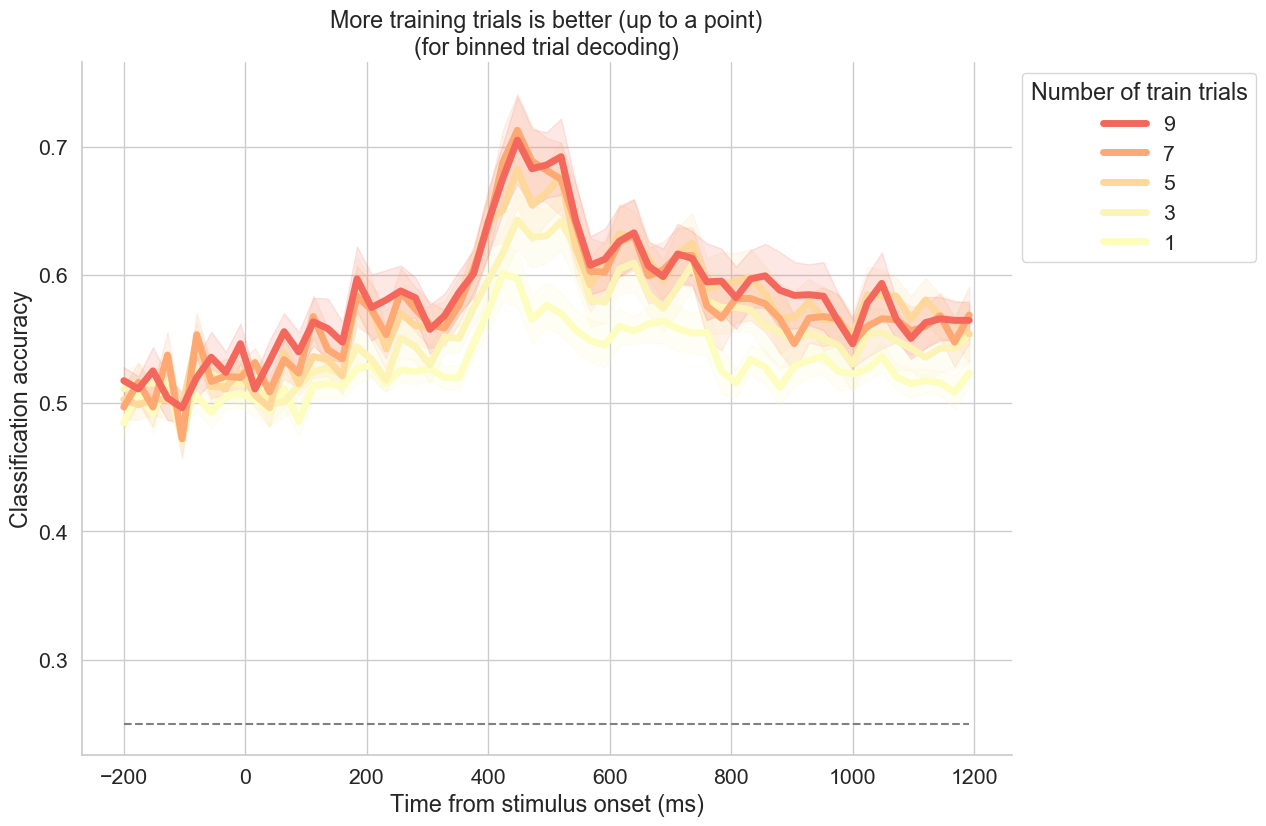

In [43]:
import seaborn as sns
sns.set_theme(style='whitegrid',font_scale=1.4) 

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('magma_r')

ax.plot(wrangl.t,np.ones((len(wrangl.t)))*.25,'--',color='gray')
# downsamp_vals = [1,2,3,5,10,15,20]
acc_mean = np.mean(acc,3)
for i in range(acc_mean.shape[0]):
    c = ((i+.00001)**2)/50
    color = cmap(c)
    mean,upper,lower = get_plot_line(acc_mean[i])
    ax.plot(wrangl.t,mean,label=downsamp_vals[i],color=color,linewidth=5)
    ax.fill_between(wrangl.t,upper,lower,alpha=.15,color=color)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Number of train trials', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('More training trials is better (up to a point)\n(for binned trial decoding)')
ax.set_xlabel('Time from stimulus onset (ms)')
ax.set_ylabel('Classification accuracy')

sns.despine()

# plt.savefig('downsamp_bin.png',dpi=500,bbox_inches='tight')
plt.show()